Тетрадка для обучения модели.

# Import

In [276]:
import os
import sys
from dotenv import load_dotenv
from tqdm import tqdm
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import ast
from scipy import stats

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

import category_encoders as ce

import torch
from torch.utils.data import Dataset

from xgboost import XGBRegressor, DeviceQuantileDMatrix


load_dotenv()
sklearn.set_config(transform_output="pandas")
pd.options.display.max_columns = None
ROOT_PATH = os.getenv("ROOT_PATH")
sys.path.append(ROOT_PATH)

In [128]:
from src.metrics import get_smoothed_mean_log_accuracy_ratio

# Config

In [129]:
INPUT_DATA_PATH = os.getenv("INPUT_DATA_PATH")
OUTPUT_DATA_PATH = os.getenv("OUTPUT_DATA_PATH")

# Classes and functions

Функции для перевода временной метки в день недели и час

In [130]:
def hour_to_weekday(hour):
    day = hour // 24
    weekday = day % 7
    return weekday


def hour_to_daytime(hour):
    return hour % 24

Перевод строки в формате "1,2,3,4" в формат [1, 2, 3, 4]

In [131]:
def str_to_list(X):
    for col in X.columns:
        X[col] = X[col].apply(lambda x: [int(v) for v in x.split(",")])
    
    return X

Функции для генерации новых признаков в validate.tsv

In [132]:
def get_interval_times(mask, history):
    users_history = history.loc[mask, ["weekday", "daytime"]]
    
    top_weekday = np.cos(2*np.pi*users_history["weekday"].mode()[0]/7)
    top_daytime = np.cos(2*np.pi*users_history["daytime"].mode()[0]/24)

    return top_weekday, top_daytime


def get_sessions_features(mask, history):
    # Берем интересующую историю активности
    users_hours = history.loc[mask, ["user_id", "hour", "cpm"]]
    # Группируем по пользователям и считаем сколько времени длилась сессия и какая была цена
    users_sessions = []
    users_cpms = []
    for _, user_data in users_hours.groupby(by="user_id"):
        user_data = user_data.sort_values(by="hour")
        hours = list(user_data["hour"])
        cpms = list(user_data["cpm"])
        # Если пользователь не видел рекламу больше 6 часов, то у него начинается новая сессия
        user_sessions = [hours[0]]
        user_cpms = [cpms[0]]
        for i, hour in enumerate(hours[1:], 1):
            if hour - user_sessions[-1] <= 6:
                user_sessions.append(hour)
                user_cpms.append(cpms[i])
                continue

            users_sessions.append(user_sessions)
            users_cpms.append(user_cpms)
            user_sessions = [hour]
            user_cpms = [cpms[i]]
        
        users_sessions.append(user_sessions)
        users_cpms.append(user_cpms)

    sessions_duration = round(np.mean([np.max(user_sessions) - np.min(user_sessions) + 1 for user_sessions in users_sessions]))
    num_sessions = len(users_sessions)
    sessions_cpm = np.mean([np.mean(user_cpms) for user_cpms in users_cpms])

    return sessions_duration, num_sessions, sessions_cpm

In [133]:
def add_num_publishers(X):
    return X["publishers"].apply(len)


def add_used_publishers_ratio(X, history):
    new_feature = {
        "used_publishers_ration": []
    }
    for _, row in X.iterrows():
        # Берем записи с пользователями и площадкам из объявления
        mask = (history["user_id"].isin(row["user_ids"])) & (history["publisher"].isin(row["publishers"]))
        users_publishers = history.loc[mask, ["publisher", "user_id"]]
        # Для каждого пользователя считаем сколько подходящих групп он использовал и берем популярное кол-во
        n_used_publishers = users_publishers.groupby("user_id")["publisher"].apply(lambda publishers: len(np.unique(publishers))).mode()[0]
        # Считаем отношение
        used_publishers_ration = n_used_publishers/len(row["publishers"])

        new_feature["used_publishers_ration"].append(used_publishers_ration)

    return pd.DataFrame(new_feature)


def add_top_intervals(X, history):
    new_feature = {
        "top_weekday": [],
        "top_daytime": [],
        "top_weekday_on_pubs": [],
        "top_daytime_on_pubs": []
    }
    for _, row in X.iterrows():
        mask = history["user_id"].isin(row["user_ids"])
        top_weekday, top_daytime = get_interval_times(mask, history)

        mask = (history["user_id"].isin(row["user_ids"])) & (history["publisher"].isin(row["publishers"]))
        top_weekday_on_pubs, top_daytime_on_pubs = get_interval_times(mask, history)

        new_feature["top_weekday"].append(top_weekday)
        new_feature["top_daytime"].append(top_daytime)
        new_feature["top_weekday_on_pubs"].append(top_weekday_on_pubs)
        new_feature["top_daytime_on_pubs"].append(top_daytime_on_pubs)

    return pd.DataFrame(new_feature)


def add_session_features(X, history):
    new_feature = {
        "sessions_duration": [],
        "sessions_duration_on_pubs": [],

        "num_sessions": [],
        "num_sessions_on_pubs": [],

        "sessions_cpm": [],
        "sessions_cpm_on_pubs": []
    }
    for _, row in X.iterrows():
        # На всех площадках
        mask = (history["user_id"].isin(row["user_ids"]))
        sessions_duration, num_sessions, sessions_cpm = get_sessions_features(mask, history)
        # На конкретных площадках
        mask = (history["user_id"].isin(row["user_ids"])) & (history["publisher"].isin(row["publishers"]))
        sessions_duration_on_pubs, num_sessions_on_pubs, sessions_cpm_on_pubs = get_sessions_features(mask, history)

        new_feature["sessions_duration"].append(sessions_duration)
        new_feature["sessions_duration_on_pubs"].append(sessions_duration_on_pubs)

        new_feature["num_sessions"].append(num_sessions)
        new_feature["num_sessions_on_pubs"].append(num_sessions_on_pubs)

        new_feature["sessions_cpm"].append(sessions_cpm)
        new_feature["sessions_cpm_on_pubs"].append(sessions_cpm_on_pubs)

    return pd.DataFrame(new_feature)


def add_views(X, history):
    new_feature = {
        "num_views": [],
        "num_views_on_pubs": []
    }
    for _, row in X.iterrows():
        num_views = (history["user_id"].isin(row["user_ids"])).sum()
        num_views_on_pubs = ((history["user_id"].isin(row["user_ids"])) & (history["publisher"].isin(row["publishers"]))).sum()

        new_feature["num_views"].append(num_views)
        new_feature["num_views_on_pubs"].append(num_views_on_pubs)

    return pd.DataFrame(new_feature)

Функция для подсчета метрики

In [238]:
def get_smoothed_log_mape_column_value(responses_column, answers_column, epsilon):
    return np.abs(np.log(
        (responses_column + epsilon)
        / (answers_column + epsilon)
    )).mean()


def get_smoothed_mean_log_accuracy_ratio_np(answers, responses, epsilon=0.005):
    answers = answers.to_numpy().reshape(len(responses), 3)
    log_accuracy_ratio_mean = np.array(
        [
            get_smoothed_log_mape_column_value(responses[:, 0], answers[:, 0], epsilon),
            get_smoothed_log_mape_column_value(responses[:, 1], answers[:, 1], epsilon),
            get_smoothed_log_mape_column_value(responses[:, 2], answers[:, 2], epsilon),
        ]
    ).mean()
    
    percentage_error = 100 * (np.exp(log_accuracy_ratio_mean) - 1)

    return percentage_error.round(
        decimals=2
    )

Функции для визуализации

In [251]:
def get_shap_values(model, X_test, y_test, save_dir_path=None):
    # Для каждой целевой переменной
    for idx, target_name in enumerate(y_test.columns):
        # Создадим экземпляр класса shap
        explainer = shap.Explainer(model.estimators_[idx])
        # Получим shap значений
        shap_values = explainer(X_test)
        # Отрисуем необходимые диаграммы
        plt.figure(figsize=(8, 6)) 
        shap.plots.bar(shap_values, show=False, max_display=len(X_test.columns))
        plt.ylim(0.5, X_test.shape[1] + 1)
        if save_dir_path:
            plt.savefig(os.path.join(save_dir_path, f"barplot_{target_name}.png"), dpi=300, bbox_inches="tight")

        plt.close()

        plt.figure(figsize=(8, 6)) 
        shap.plots.beeswarm(shap_values, show=False, max_display=len(X_test.columns))
        plt.ylim(0.5, X_test.shape[1] + 1)
        if save_dir_path:
            plt.savefig(os.path.join(save_dir_path, f"beeswarm_{target_name}.png"), dpi=300, bbox_inches="tight")

        plt.close()

Функция для кросс-валидации

In [ ]:
def ccross_val(model, X, y, verbose=True):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = {
        "train_times": [],
        "inference_times": [],
        "metrics": []
    }
    for train_idx, test_idx in cv.split(X):
        # Обучаем модель
        start = time.time()

        model.fit(X.iloc[train_idx], y.iloc[train_idx])

        train_time = time.time() - start
        # Получаем предсказания
        start = time.time()

        y_pred = model.predict(X.iloc[test_idx])

        inference_time = time.time() - start
        # Делаем постобработку
        y_pred[y_pred < 0.] = 0.
        # Считаем метрику
        metric = get_smoothed_mean_log_accuracy_ratio_np(y.iloc[test_idx], y_pred)

        scores["train_times"].append(train_time)
        scores["inference_times"].append(inference_time)
        scores["metrics"].append(metric)

    if verbose:
        print(f"Train size: {len(train_idx)}\nTest size: {len(test_idx)}")
        print(f"Mean train time: {round(np.mean(scores['train_times']), 2)} s")
        print(f"Mean inference time: {round(np.mean(scores['inference_times']), 2)} s")
        print(f"Mean metric: {round(np.mean(scores['metrics']), 2)}")

# Load data

### load

In [137]:
ext_user_ds_path = os.path.join(OUTPUT_DATA_PATH, "ext_users.csv")
ext_history_ds_path = os.path.join(OUTPUT_DATA_PATH, "ext_history.csv")
validate_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/validate.tsv")
validate_answers_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/validate_answers.tsv")

ext_user_ds = pd.read_csv(ext_user_ds_path)
ext_history_ds = pd.read_csv(ext_history_ds_path)
validate_ds = pd.read_csv(validate_ds_path, sep="\t")
validate_answers_ds = pd.read_csv(validate_answers_ds_path, sep="\t")

### preprocess

Считаем

In [ ]:
ct = make_column_transformer(
    (FunctionTransformer(str_to_list), ["publishers", "user_ids"]),

    remainder='passthrough',
    verbose_feature_names_out=False
)

fe_ct = ColumnTransformer([
    ("add_num_publishers",
     FunctionTransformer(func=add_num_publishers,
                         feature_names_out=lambda *_: ["num_publishers"]),
     ["publishers"]),

     ("add_used_publishers_ratio",
     FunctionTransformer(func=add_used_publishers_ratio,
                         feature_names_out=lambda *_: ["used_publishers_ration"],
                         kw_args={"history": ext_history_ds}),
     ["user_ids", "publishers"]),

     ("add_top_intervals",
     FunctionTransformer(func=add_top_intervals,
                         feature_names_out=lambda *_: ["top_weekday", "top_daytime", "top_weekday_on_pubs", "top_daytime_on_pubs"],
                         kw_args={"history": ext_history_ds}),
    ["user_ids", "publishers"]),

    ("add_session_features",
     FunctionTransformer(func=add_session_features,
                         feature_names_out=lambda *_: ["sessions_duration", "sessions_duration_on_pubs", "num_sessions", "num_sessions_on_pubs", "sessions_cpm", "sessions_cpm_on_pubs"],
                         kw_args={"history": ext_history_ds}),
    ["user_ids", "publishers"]),
     
    ("add_views",
     FunctionTransformer(func=add_views,
                         feature_names_out=lambda *_: ["num_views", "num_views_on_pubs"],
                         kw_args={"history": ext_history_ds}),
    ["user_ids", "publishers"])
    ],
    remainder='passthrough',
    n_jobs=12,
    verbose=True,
    verbose_feature_names_out=False
)

In [140]:
validate_ds = ct.fit_transform(validate_ds)
ext_validate_ds = fe_ct.fit_transform(validate_ds)
ext_validate_ds.head()

[ColumnTransformer]  (1 of 6) Processing add_num_publishers, total=   0.0s
[ColumnTransformer] ..... (6 of 6) Processing remainder, total=   0.0s
[ColumnTransformer] ..... (5 of 6) Processing add_views, total=  37.4s
[ColumnTransformer]  (3 of 6) Processing add_top_intervals, total=  45.1s
[ColumnTransformer]  (2 of 6) Processing add_used_publishers_ratio, total=  46.1s
[ColumnTransformer]  (4 of 6) Processing add_session_features, total=12.7min


,num_publishers,used_publishers_ration,top_weekday,top_daytime,top_weekday_on_pubs,top_daytime_on_pubs,sessions_duration,sessions_duration_on_pubs,num_sessions,num_sessions_on_pubs,sessions_cpm,sessions_cpm_on_pubs,num_views,num_views_on_pubs,cpm,hour_start,hour_end,audience_size
0,2,0.500000,-0.900969,0.258819,1.000000,-0.965926,2,2,37327,2661,221.736712,304.767717,77321,4598,220.0,1058,1153,1906
1,2,0.500000,-0.222521,0.258819,-0.900969,0.500000,3,3,70595,3922,182.222638,189.190416,178007,10967,312.0,1295,1301,1380
2,6,0.166667,-0.900969,0.500000,0.623490,0.500000,2,2,18025,16165,231.532268,232.619346,39052,34691,70.0,1229,1249,888
3,2,0.500000,-0.222521,-0.965926,-0.222521,0.258819,2,2,8304,5054,215.579714,224.737393,17013,10146,240.0,1295,1377,440
4,4,0.250000,-0.222521,0.500000,1.000000,0.500000,2,2,25286,20591,266.370060,272.764926,52434,42564,262.0,752,990,1476


Берем готовое

In [ ]:
ext_validate_ds_path = os.path.join(OUTPUT_DATA_PATH, "ext_validate.csv")
ext_validate_ds = pd.read_csv(ext_validate_ds_path)
ext_validate_ds.head()

,num_publishers,used_publishers_ration,top_weekday,top_daytime,top_weekday_on_pubs,top_daytime_on_pubs,sessions_duration,sessions_duration_on_pubs,num_sessions,num_sessions_on_pubs,sessions_cpm,sessions_cpm_on_pubs,num_views,num_views_on_pubs,cpm,hour_start,hour_end,audience_size
0,2,0.500000,-0.900969,0.258819,1.000000,-0.965926,2,2,37327,2661,221.736712,304.767717,77321,4598,220.0,1058,1153,1906
1,2,0.500000,-0.222521,0.258819,-0.900969,0.500000,3,3,70595,3922,182.222638,189.190416,178007,10967,312.0,1295,1301,1380
2,6,0.166667,-0.900969,0.500000,0.623490,0.500000,2,2,18025,16165,231.532268,232.619346,39052,34691,70.0,1229,1249,888
3,2,0.500000,-0.222521,-0.965926,-0.222521,0.258819,2,2,8304,5054,215.579714,224.737393,17013,10146,240.0,1295,1377,440
4,4,0.250000,-0.222521,0.500000,1.000000,0.500000,2,2,25286,20591,266.370060,272.764926,52434,42564,262.0,752,990,1476


# Train model

## XGBRegression

### setup

In [285]:
xgb = XGBRegressor(
    device="cuda",
    random_state=42,

    n_estimators=1000,
    learning_rate=0.05,
    gamma=0,
    max_depth=6,
    reg_lambda=1,
    tree_method="hist",

    objective="reg:gamma"
)

model = MultiOutputRegressor(
    estimator=xgb,
    n_jobs=8
)

In [286]:
X_train, X_test, y_train, y_test = train_test_split(ext_validate_ds, validate_answers_ds, test_size=0.2, random_state=42)

### train

In [288]:
model.fit(X_train, y_train+0.0005)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            device='cuda',
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='reg:gamma', ...),
                     n_jobs=8)

Подбор гиперпараметров модели

In [ ]:
# Гиперпараметры для поиска
param_dist = {
    "estimator__n_estimators": [100, 300, 500, 1000],
    # "estimator__learning_rate": [0.005, 0.01, 0.05, 0.1],
    # "estimator__max_depth": [3, 5, 6, 8, 10],
    # "estimator__gamma": [0, 0.1, 0.2, 0.5],
    # "estimator__reg_lambda": [0.1, 1, 10],
    # "estimator__subsample": [0.6, 0.8, 1.0],
    # "estimator__colsample_bytree": [0.6, 0.8, 1.0],
    "estimator__objective": ["reg:logistic", "reg:squarederror", "reg:pseudohubererror", "reg:gamma"]
}


from sklearn.metrics import mean_squared_error
smlar = make_scorer(get_smoothed_mean_log_accuracy_ratio_np, greater_is_better=False, epsilon=0.005)
# Настройка HalvingRandomSearchCV
search = HalvingRandomSearchCV(
    estimator=model,
    param_distributions=param_dist,
    factor=3,
    resource="n_samples",
    max_resources=1000,
    cv=3,
    scoring=mean_squared_error,
    return_train_score=True,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Запуск поиска
search.fit(X_train, y_train)

In [ ]:
# Вывод лучших параметров
print("Best parameters:", search.best_params_)
print("Best score:", search.best_score_)

# Оценка на тесте
best_model = search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test score:", test_score)

### evaluate

In [289]:
y_pred = model.predict(X_test)
y_pred[y_pred < 0.] = 0.
print(get_smoothed_mean_log_accuracy_ratio_np(y_test, y_pred))

59.17


/home/chernovec/projects/VILLKA/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:05:45] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/chernovec/projects/VILLKA/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:05:45] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the dev

In [250]:
save_dir_path = os.path.join(OUTPUT_DATA_PATH, "plots/shap")
os.makedirs(save_dir_path, exist_ok=True)
get_shap_values(model, X_test, y_test, save_dir_path)

In [291]:
ccross_val(model, ext_validate_ds, validate_answers_ds+0.0005)

/home/chernovec/projects/VILLKA/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:06:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/chernovec/projects/VILLKA/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:06:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the dev

Train size: 807
Test size: 201
Mean train time: 9.54 s
Mean inference time: 0.24 s
Mean metric: 60.24


# Deprecate

<Axes: xlabel='hour_start_old'>

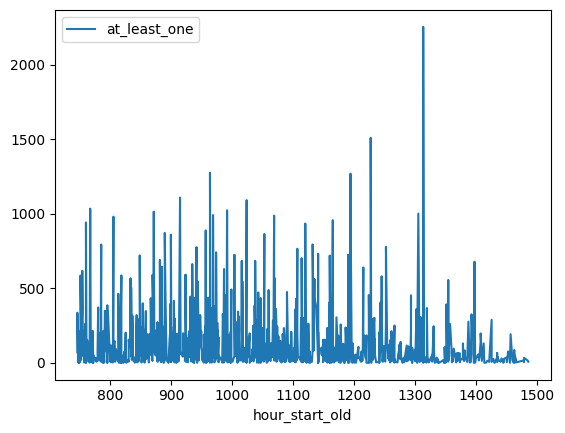

In [19]:
ds.plot(x="hour_start_old", y="at_least_one")

In [69]:
scaler = MinMaxScaler()
scaled_ds = scaler.fit_transform(ds[['cpm', 'hour_start_old', 'hour_end', 'audience_size', 'weekday_start',
                                     'duration', 'hour_start', 'publisher_quantity',
                                     'top_time_month', 'top_time_week',
                                     'top_weekday_month', 'top_weekday_week', 'session_duration_month_mean',
                                     'session_duration_week_mean', 'session_quantity_month',
                                     'session_quantity_week', 'session_cpm_month_mean',
                                     'session_cpm_week_mean', 'views_month_mean', 'views_week_mean']])
scaled_ds.head()

,cpm,hour_start_old,hour_end,audience_size,weekday_start,duration,hour_start,publisher_quantity,top_time_month,top_time_week,top_weekday_month,top_weekday_week,session_duration_month_mean,session_duration_week_mean,session_quantity_month,session_quantity_week,session_cpm_month_mean,session_cpm_week_mean,views_month_mean,views_week_mean
0,0.011236,0.000000,0.072109,0.318182,0.5,0.113772,0.5,0.6,0.869565,0.956522,0.333333,0.500000,0.333333,0.333333,0.115303,0.111520,0.152296,0.133979,0.078562,0.075623
1,0.074157,0.000000,0.274830,0.354545,0.5,0.411178,0.5,0.2,0.913043,0.652174,0.333333,0.000000,0.333333,0.333333,0.097731,0.099001,0.055173,0.047122,0.055789,0.059092
2,0.359551,0.001355,0.095238,0.413636,0.5,0.145709,0.5,0.0,0.913043,0.956522,0.333333,0.333333,0.333333,0.333333,0.122182,0.124250,0.143588,0.130412,0.080127,0.083367
3,0.269663,0.001355,0.361905,0.180000,0.5,0.536926,0.5,0.2,0.869565,0.913043,0.000000,0.166667,0.333333,0.333333,0.082915,0.080326,0.153245,0.118046,0.056979,0.055118
4,0.022472,0.001355,0.009524,0.014545,0.5,0.019960,0.5,0.8,0.913043,0.695652,0.333333,0.500000,0.333333,0.333333,0.039329,0.036718,0.141434,0.129627,0.027831,0.026066


In [73]:
X = pd.concat([scaled_ds, ds["used_publishers_ration"]], axis=1)
y = ds[["at_least_one", "at_least_two", "at_least_three"]]

In [75]:
tscv = TimeSeriesSplit(
    n_splits=6,  # Количество разбиений
    test_size=100,  # Размер тестового набора
    # gap=10  # Промежуток между train и test
)
xgb = XGBRegressor(
    device="cuda",
    random_state=42,

    learning_rate=0.05,
    gamma=0,
    max_depth=6,
    reg_lambda=1,
    tree_method="hist",

    objective="reg:gamma"
)
model = MultiOutputRegressor(
    xgb
)

In [76]:
for train_index, test_index in tscv.split(X):
    print("Обучающий:", len(train_index), "Тестовый:", len(test_index))

Обучающий: 408 Тестовый: 100
Обучающий: 508 Тестовый: 100
Обучающий: 608 Тестовый: 100
Обучающий: 708 Тестовый: 100
Обучающий: 808 Тестовый: 100
Обучающий: 908 Тестовый: 100


In [101]:
# Для сбора метрик
all_preds = []
all_true = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Обучение модели
    model.fit(X_train, y_train+0.1)
    
    # Прогноз на тестовом наборе
    y_pred = model.predict(X_test)
    
    # Сохранение результатов
    all_preds.extend(y_pred)
    all_true.extend(y_test.values)
    
    # Оценка для текущего фолда
    mae_total = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    print(f"MAE для каждого выхода: {mae_total}")

MAE для каждого выхода: [85.25302  52.858524 40.972847]
MAE для каждого выхода: [87.32217  50.507725 36.76038 ]
MAE для каждого выхода: [88.41054  49.866554 36.36864 ]
MAE для каждого выхода: [99.14325  54.767246 35.148197]
MAE для каждого выхода: [71.89995  39.87612  25.010744]
MAE для каждого выхода: [41.68403  15.879536 10.066034]


In [102]:
mae_total = mean_absolute_error(all_true, all_preds, multioutput='raw_values')
print(f"MAE для каждого выхода: {mae_total}")

MAE для каждого выхода: [78.95215611 43.95928375 30.72114075]


In [79]:
responses = pd.DataFrame(data=model.predict(X), columns=["at_least_one", "at_least_two", "at_least_three"])
responses = responses.apply(round)
responses

,at_least_one,at_least_two,at_least_three
0,53.0,21.0,9.0
1,113.0,82.0,73.0
2,63.0,28.0,10.0
3,68.0,46.0,32.0
4,6.0,1.0,0.0
...,...,...,...
1003,1.0,0.0,0.0
1004,19.0,0.0,0.0
1005,3.0,0.0,0.0
1006,22.0,0.0,0.0


In [80]:
responses.describe()

,at_least_one,at_least_two,at_least_three
count,1008.000000,1008.000000,1008.000000
mean,69.368057,40.347221,29.511906
std,66.157547,57.312229,50.284790
min,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000
50%,47.000000,11.000000,1.000000
75%,106.000000,62.000000,39.000000
max,259.000000,253.000000,241.000000


In [81]:
answers = y.apply(lambda x: x/ds.loc[x.index, "audience_size"])
# answers.to_csv(os.path.join(OUTPUT_DATA_PATH, "answers.csv"))

In [85]:
res = responses.apply(lambda x: x/ds.loc[x.index, "audience_size"])
# res.to_csv(os.path.join(OUTPUT_DATA_PATH, "responses.csv"))

In [86]:
get_smoothed_mean_log_accuracy_ratio(answers, res)

np.float64(35.07)

In [87]:
def check_features_with_targets_conversion(features_df, target_dfs):
    
    for feature_name in features_df.columns:
        feature = features_df[feature_name]
        # если нужно, то фильтруем строки
        if "publisher_" in feature_name:
            feature = feature[feature > 0]
        # берем те же строки для целевой переменной
        target_values = target_dfs.loc[feature.index]
        # считаем корреляцию
        correlations = target_values.corrwith(feature)

        # Отрисуем корреляцию на графиках
        plt.figure(figsize=(8, 6)) 
        sns.barplot(x=correlations.index, y=correlations.values)
        plt.xlabel('Целевые переменные', fontsize=12)
        plt.ylabel(f'Корреляция с {feature_name}', fontsize=12)
        plt.title(f'Корреляция между {feature_name} и целевыми переменными', fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DATA_PATH, f"plots/{feature_name}_correlation_with_target_values.png"), dpi=300)
        plt.close()

In [89]:
check_features_with_targets_conversion(X, y)